# Linear Regression exercise

Last revised: 30-Aug-2020 by Christian Forssén [christian.forssen@chalmers.se]

## Import modules

In [2]:
# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
sns.set('talk')

## Generate data

In [3]:
# Let us generate noisy data with a linear feature

# to make this notebook's output stable across runs
np.random.seed(42)

# X are picked uniform random [0,2]
X = 2 * np.random.rand(100, 1)
# Linear relation to the predicted value, but with Gaussian noise (mean=0, variance=1)
y = 2 + 4 * X + np.random.randn(100, 1)

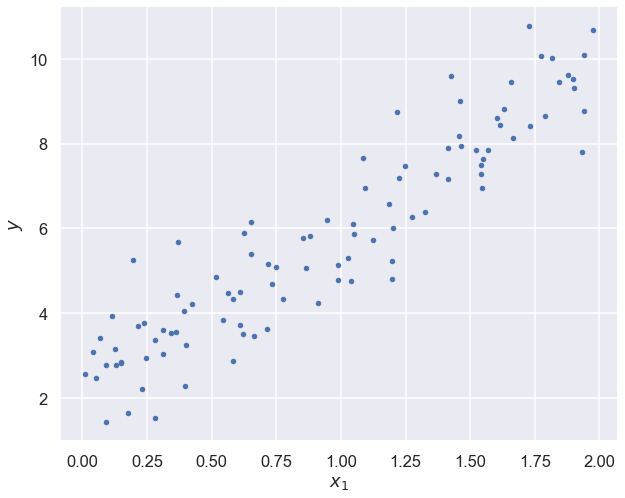

In [4]:
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(X, y, "b.")
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$y$');

## Linear regression

### Linear regression using scikit-learn

In [5]:
# Fit the linear regression model with sklearn
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, y)

# Print the linear regression parameters (with a specified precision)
with np.printoptions(precision=4):
    print(lin_reg.intercept_, lin_reg.coef_)

[2.2151] [[3.7701]]


In [6]:
X_predict = np.array([[0], [2]])
y_predict = lin_reg.predict(X_predict)

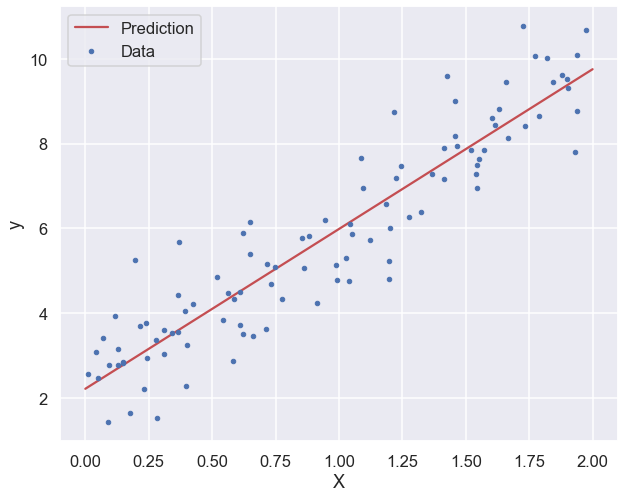

In [7]:
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(X_predict, y_predict, "r-",label="Prediction")
ax.plot(X, y, "b.",label="Data")
ax.set_xlabel('X')
ax.set_ylabel('y')
ax.legend(loc='best');

### Linear regression using the Normal Equation

Let us create the design matrix `X_d` for the linear model.
It is a linear model with two features corresponding to the two terms in a polynom of order 1:
- an X^0 (bias)
- an X^1 (linear feature) 

In [8]:
m = len(X) # number of instances
# The design matrix will have shape (m x 2)
# It is created by adding X^0 = 1 to each instance
X_d = np.c_[np.ones((m, 1)), X]  



In [9]:
print(X_d.shape)
print(np.matmul(np.transpose(X_d),X_d).shape)
print(y.shape)
print(np.transpose(X_d).shape)

(100, 2)
(2, 2)
(100, 1)
(2, 100)


[[2.21509616]
 [3.77011339]]


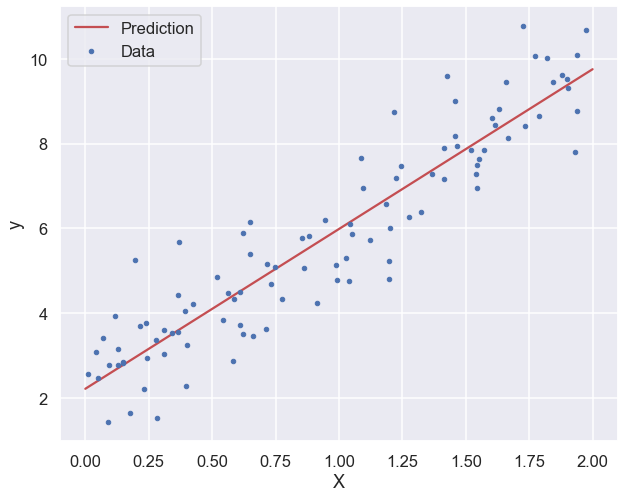

In [10]:
### EXERCISE
#
# (a) Use the normal equation to compute the fit parameters
# (b) Print the best fit parameters
# (c) Plot the fitted linear model together with the data
#
#
#
theta = np.matmul(np.linalg.inv(np.matmul(np.transpose(X_d),X_d)),np.matmul(np.transpose(X_d),y))
print(theta)
Y_predict_new = [theta[1]*X_predict[0] + theta[0], theta[1]*X_predict[1] + theta[0]]

fig, ax = plt.subplots(figsize=(10,8))
ax.plot(X_predict, Y_predict_new, "r-",label="Prediction")
ax.plot(X, y, "b.",label="Data")
ax.set_xlabel('X')
ax.set_ylabel('y')
ax.legend(loc='best');

### COMMENT on the base for the sklearn LinearRegression method

The `LinearRegression` class is based on the `scipy.linalg.lstsq()` function (the name stands for "least squares"), which you could call directly:

In [11]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_d, y, rcond=1e-6)
theta_best_svd

array([[2.21509616],
       [3.77011339]])

This function computes $\mathbf{X}^+\mathbf{y}$, where $\mathbf{X}^{+}$ is the _pseudoinverse_ of $\mathbf{X}$ (specifically the Moore-Penrose inverse). You can use `np.linalg.pinv()` to compute the pseudoinverse directly:

In [12]:
np.linalg.pinv(X_d).dot(y)

array([[2.21509616],
       [3.77011339]])

### Linear regression using batch gradient descent

In [13]:
# learning hyperparameter
eta = 0.1
# number of iterations
n_iterations = 1000
m = len(X)
# initial guess for parameter vector
theta = np.random.randn(2,1)

In [18]:
for iteration in range(n_iterations):
    gradients = 2/m * X_d.T.dot(X_d.dot(theta) - y)
    theta = theta - eta * gradients
print(gradients)

[[-1.72306613e-15]
 [ 2.06723527e-15]]


In [39]:
with np.printoptions(precision=4):
    print(theta)

[[2.2151]
 [3.7701]]


In [40]:
X_predict = np.array([[0], [2]])
X_predict_d = np.c_[np.ones((2, 1)), X_predict]  
X_predict_d.dot(theta)

array([[2.21509616],
       [9.75532293]])

In [41]:
def plot_gradient_descent(theta, X, y, eta=0.1, theta_path=None,ax=None,n_iterations=1000):
    '''Plot the iterations of batch gradient descent.'''
    m = len(X)
    if not ax:
        fig,ax = plt.subplots(1,1)
    ax.plot(X, y, "b.")
    
    _X_d = np.c_[np.ones((m, 1)), X]  
    _X_predict = np.array([np.floor(min(X)),np.ceil(max(X))])
    _X_predict_d = np.c_[np.ones((2, 1)), X_predict]
    
    for iteration in range(n_iterations):
        if iteration < 10:
            _y_predict = _X_predict_d.dot(theta)
            style = "b-" if iteration > 0 else "r--"
            ax.plot(_X_predict, _y_predict, style)
        gradients = 2/m * _X_d.T.dot(_X_d.dot(theta) - y)
        theta = theta - eta * gradients
        if theta_path is not None:
            theta_path.append(theta)
    ax.set_xlabel("$x_1$")
    ax.set_title(r"$\eta = {}$ (10 iter.)".format(eta))

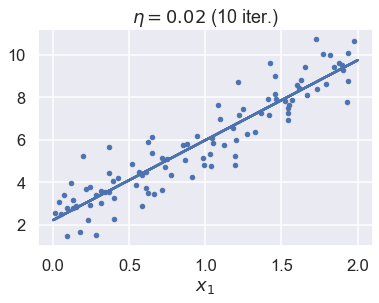

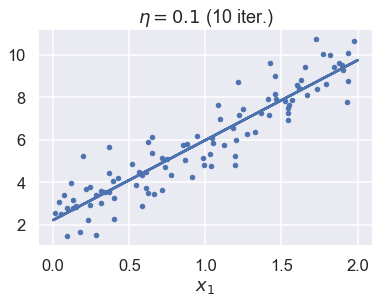

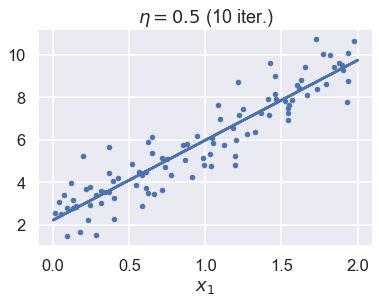

In [42]:
# EXERCISE
#
#
# Explore the learning rates with different learning hyperparameter 
# eta = 0.02, 0.1, 0.5
#
# Plot the different learning rates using the `plot_gradient_descent` function defined above.

plot_gradient_descent(theta,X,y,0.02)
plot_gradient_descent(theta,X,y,0.1)
plot_gradient_descent(theta,X,y,0.5)



### Advanced topic: Linear regression using Stochastic Gradient Descent

Let us implement an algorithm that performs *stochastic gradient descent*.

By convention we iterate by rounds of m (m = # of instances) iterations; each round is called an **epoch**. We will use much fewer epochs that we did for the batch gradient descent approach, thereby losing accuracy but gaining speed.

We will use a learning schedule in which we first take large steps, and then shorter and shorter ones. This approach is similar in spirit to the optimization algorithm *simulated annealing*.

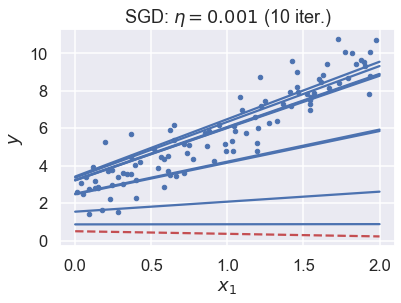

In [43]:
m = len(X)
np.random.seed(42)

n_epochs = 50
t0, t1 = 5, 50  # learning schedule hyperparameters

# We will store the iterations in a list to monitor the convergence
theta_path_sgd = []

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2,1)  # random initialization

fig,ax = plt.subplots(1,1)

for epoch in range(n_epochs):
    for i in range(m):
        if epoch == 0 and i < 10:                    
            y_predict = X_predict_d.dot(theta) 
            style = "b-" if i > 0 else "r--" 
            ax.plot(X_predict, y_predict, style) 
        # pick a random instance
        random_index = np.random.randint(m)
        xi = X_d[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients
        theta_path_sgd.append(theta)    

ax.plot(X, y, "b.")           
ax.set_xlabel("$x_1$")           
ax.set_ylabel("$y$")
ax.set_title(f"SGD: $\eta = {eta:.3f}$ (10 iter.)");

In [44]:
theta

array([[2.21140454],
       [3.74797916]])

In [45]:
# The Stochastic Gradient Descent optimizer is built-in scikit-learn
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter=50, tol=-np.infty, penalty=None, eta0=0.1, random_state=42)
sgd_reg.fit(X, y.ravel())

SGDRegressor(eta0=0.1, max_iter=50, penalty=None, random_state=42, tol=-inf)

In [46]:
sgd_reg.intercept_, sgd_reg.coef_

(array([2.16782317]), array([3.7260286]))

### Advanced topic: Mini-batch gradient descent

Instead of computing the gradients based on the full training set (as in batch gradient descent [BGD}), or based on a single instance (as in stochastic gradient descent [SGD}) there is a third alternative: **mini-batch gradient descent** [MGD]:
- For each step, use a random subset of the training data (say 10-25%) and compute the gradient based on that.
- An epoch is defined as several such steps after which you have used all instances of training data. E.g. if the mini-batch size is 10% of all instances, then 10 non-overlapping steps would exhaust all data and would correspond to one epoch.
- It is suggested to use a learning schedule with smaller and smaller steps.

The advantages of the mini-batch gradient descent are the following:
- The convergence is less erratic than with SGD, while still being much faster than full BGD.
- The gradient computation for a mini-batch is a matrix operation, which means that the algorithm can get a performance boost from hardware optimization, especially when using GPUs.

## Important note on gradient descent methods

Gradient descent is a general optimization algorithm. However, there are several important issues that should be known before using it:
1. It requires the computation of partial derivatives of the cost function. This is straight-forward for the linear regression method, but can be difficult for other models. The use of **automatic differentiation** is very popular in the ML community,and is well worth exploring. 
1. In principle, gradient descent works well for convex cost functions, i.e. where the gradient will eventually direct you to the position of the global minimum. Again, the linear regression problem is favorable because you can show that the cost function has that property. However, most cost functions---in particular in many dimensions---correspond to very **complicated surfaces with many local minima**. In those cases, gradient descent is often not a good method.

## Linear regression with higher-degree polynomials

Any basis-expansion model that is linear in the parameters is a linear model. 

Here we will consider a case in which we use at least quadratic features in our model. This is sometimes known as *polynomial regression*, but this label is really a misnomer since it is still a linear regression problem.

In [47]:
import numpy as np

In [48]:
# Let us generate some cubic data
m = 100
minX = -3
maxX = 3
np.random.seed(1)
X = (maxX-minX) * np.random.rand(m, 1) + minX
# up to cubic features, plus random noise
theta_true = np.array([2, 1, 0.5, -0.25])
eps_noise = 1.
y = eps_noise * np.random.randn(m, 1)
for order in range(len(theta_true)):
    y += theta_true[order] * X**order

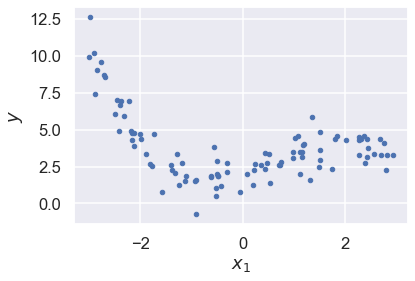

In [49]:
# Plot the data. It is pretty tricky to see the features
fig,ax = plt.subplots(1,1)

ax.plot(X, y, "b.")
ax.set_xlabel("$x_1$")
ax.set_ylabel("$y$");

### using scikit-learn

In the following we use the `LinearRegression` class from scikit-learn. You can equally well construct the design matrix and solve the normal equation explicitly with linear algebra.

The `PolynomialFeatures` class offers a fast way to construct the design matrix with all features up to a specified degree.

Note that problems with more than one input dimension would then contain mixtures up to that degree. E.g., degree-two polynomial features for a problem with $x_1$ and $x_2$ would contain the following features:
1 
; $x_1$
; $x_2$
; $x_1^2$
; $x_2^2$
; $x_1 x_2$

In [50]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=3, include_bias=False)
X_poly = poly_features.fit_transform(X)

In [51]:
# Note that the first element of the instance vector is
X[0]

array([-0.49786797])

In [52]:
# while the first element of the design matrix is
# NOTE that we have excluded the bias term (x^0). 
# This term will later be added in the linear regression
X_poly[0]

array([-0.49786797,  0.24787252, -0.12340779])

In [53]:
# perform the fit
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)

# note the bias term, which is the attribute `intercept_` from the fit
lin_reg.intercept_, lin_reg.coef_

(array([1.96984865]), array([[ 1.02594731,  0.53415279, -0.26334408]]))

In [54]:
# EXERCISE
#
# Compare to the "known" amplitudes of the different features. Why doesn't the fit parameters agree better?
#
#
#

In [55]:
# Make predictions with the linear regression model on a linear grid of new points
# The PolynomialFeatures.transfom method is useful for preparing the new data for a prediction,
# but it is picky with the shape of the input vector.
X_new=np.linspace(minX, maxX, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)

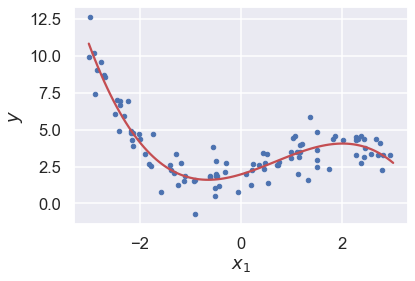

In [56]:
# EXERCISE
#
# Plot the data and the prediction
#
#

fig,ax = plt.subplots(1,1)

ax.plot(X, y, "b.")
ax.plot(X_new,y_new, "-r")
ax.set_xlabel("$x_1$")
ax.set_ylabel("$y$");

## Over- and underfitting

We will explore fitting to models that have both too many and too few features.

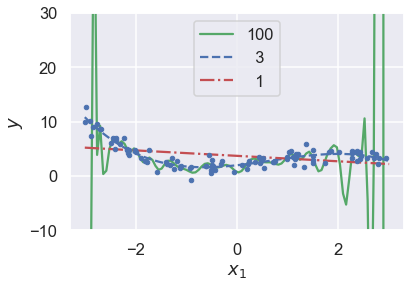

In [57]:
# For these fits we will employ scaling of the data
# We use the built-in StandardScaler to rescale the data to zero mean and unit variance.
# This will make the fit more stable
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

fig,ax = plt.subplots(1,1)

for style, degree in (("g-", 100), ("b--", 3), ("r-.", 1)):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    # Here we use a Pipeline that assembles several steps that we
    # previously applied sequentially:
    # 1. The data is transformed to the chosen polynomial features.
    # 2. The data is transformed to mean=0 and variance=1 (usually makes it numerically more stable)
    # 3. Perform the linear regression fit
    polynomial_regression = Pipeline([
            ("poly_features", polybig_features),
            ("std_scaler", std_scaler),
            ("lin_reg", lin_reg),
        ])
    polynomial_regression.fit(X, y)
    y_newbig = polynomial_regression.predict(X_new)
    ax.plot(X_new, y_newbig, style, label=f'{degree:>3}')


ax.plot(X, y, "b.")
ax.legend(loc="best")
ax.set_xlabel("$x_1$")
ax.set_ylim([-10,30])
ax.set_ylabel("$y$");

- Note how the high-degree polynomial produces a very wiggly curve that tries very hard to go through the training data. The model explodes near the edges where there is no more training data. 
- The first degree polynomial, on the other hand, fails to pick up some trends in the data that is clearly there. 

In [58]:
# EXERCISE
#
# Which of these models would you label as **overfitting** and which one as **underfitting** the data?

### Learning curves

In order to gauge a model's generalization performance (predictive power) it is common to split the data into a *training set* and a *validation set*. We will also see examples of a third set called the *test set*.

**Learning curves** are plots of the model's performance on both the training and the validation sets, measured by some performance metric such as the mean squared error. This measure is plotted as a function of the size of the training set, or alternatively as a function of the training iterations.

#### Performance metric

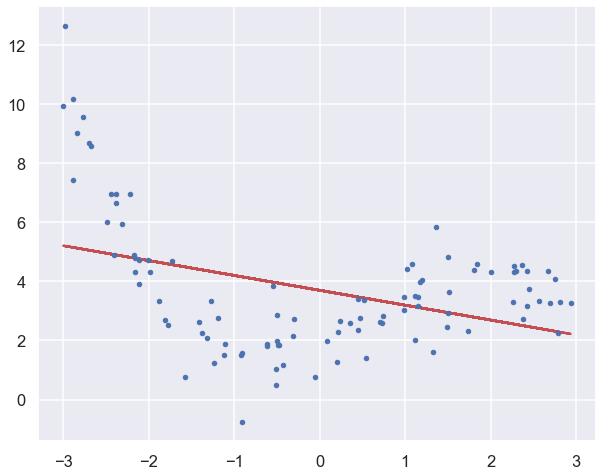

In [59]:
# EXERCISE
#
# Before moving on, let us first make sure to understand the mean_squared_error metric.
# Perform the training of a first-order polynomial model to the cubic data that we just generated.

lin_reg = LinearRegression()
lin_reg.fit(X, y)
y_predict = lin_reg.predict(X)

fig, ax = plt.subplots(figsize=(10,8))
ax.plot(X, y_predict, "r-",label="Prediction")
ax.plot(X, y, "b.",label="Data");

In [60]:
# EXERCISE
#
# Write your own function that evaluates the mean-squared-error metric on the training set. 

def mse(X,y):
    y_predict = lin_reg.predict(X)
    mse = 

SyntaxError: invalid syntax (<ipython-input-60-3f988eca3a4b>, line 7)

$\mathrm{MSE} = \frac{1}{m}\sum_{i=1}^m \left(y_i - y_{\mathrm{predict},i} \right)^2$

In [ ]:
# EXERCISE
#
# Then import the built-in convenience function from sckikit-learn for computing the MSE metric
from sklearn.metrics import mean_squared_error
# and use it to compute the same metric. The numbers should agree.

#### Learning curves

In [65]:
# built-in convenience function for computing the MSE metric
from sklearn.metrics import mean_squared_error
# built-in convenience function for splitting data
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y, ax=None):
    # split the data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.7, random_state=42)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    if not ax:
        fig,ax = plt.subplots(1,1)
    ax.plot(np.sqrt(train_errors), "r-+", label="train")
    ax.plot(np.sqrt(val_errors), "b-", label="validation")
    ax.legend(loc="best")
    ax.set_xlabel("Training set size")
    ax.set_ylabel("MSE")

Let us use a first-order polynomial to model the training data and plot the learning curve. Recall that a low mean-square error implies that the model predicts the data very well.

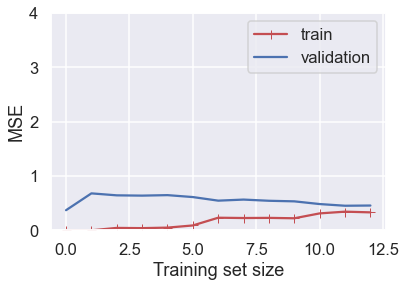

In [66]:
lin_reg = LinearRegression()
fig,ax = plt.subplots(1,1)
plot_learning_curves(lin_reg, X, y, ax=ax)
ax.set_ylim([0,4]);

Several features deserves to be mentioned:
1. The performance on the training set starts at zero when only 1-2 data are in the training set.
1. The error on the training set then increases steadily as more data is added. 
1. It finally reaches a plateau.
1. The validation error is initially very high, but reaches a plateau that is very close to the training error.

In [67]:
# EXERCISE
#
# This features in a learning curve are typical for a model that underfits. 
# Can you explain / understand why that is?

Now let us try a very high degree polynomial, which should be overfitting the data.

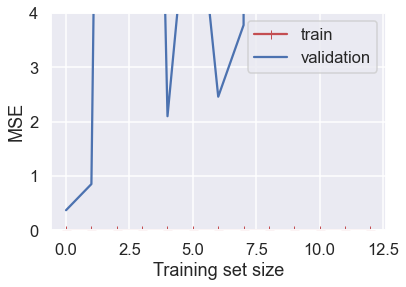

In [68]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
        ("poly_features", PolynomialFeatures(degree=15, include_bias=False)),
        ("lin_reg", LinearRegression()),
    ])

fig,ax = plt.subplots(1,1)
plot_learning_curves(polynomial_regression, X, y, ax=ax)
ax.set_ylim([0,4]);

These learning curves are similar to the underfitting model; but there are some important differences:
1. The training error is much smaller than with the linear model.
1. There is no clear plateau.
1. There is a gap between the curves, which implies that the model performs significantly better on the training data than on the validation set.

Both these examples that we have just studied demonstrate the so called **bias-variance tradeoff**.
- A high bias model has a relatively large error, most probably due to wrong assumptions about the data features.
- A high variance model is excessively sensitive to small variations in the training data.
- The irreducible error is due to the noisiness of the data itself. It can only be reduced by obtaining better data.

We seek a more systematic way of distinguishing between under- and overfitting models, and for quantification of the different kinds of errors. 

We will find that **Bayesian statistics** has the promise to deliver on that ultimate goal.

First, however, we study a common approach to avoid overfitting--namely **regularization**. We will later provide a Bayesian interpretation of this approach.

## Regularized models

### Ridge regression

In [61]:
from sklearn.linear_model import Ridge

In [62]:
# Let's generate some noisy data with a linear feature.
np.random.seed(1)
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + 0.5 * np.random.randn(m, 1) 
X_new = np.linspace(0, 3, 100).reshape(100, 1)

In [63]:
def train_ridge_model(X_train, y_train, alpha, X_predict=None, degree=1, **model_kargs):
    model = Ridge(alpha, **model_kargs) if alpha > 0 else LinearRegression()
    model = Pipeline([
        ("poly_features", PolynomialFeatures(degree=degree, include_bias=False)),
        ("std_scaler", StandardScaler()),
        ("regul_reg", model),
        ])
    model.fit(X_train, y_train)
    if not len(X_predict):
        X_predict=X_train
    return model.predict(X_predict)

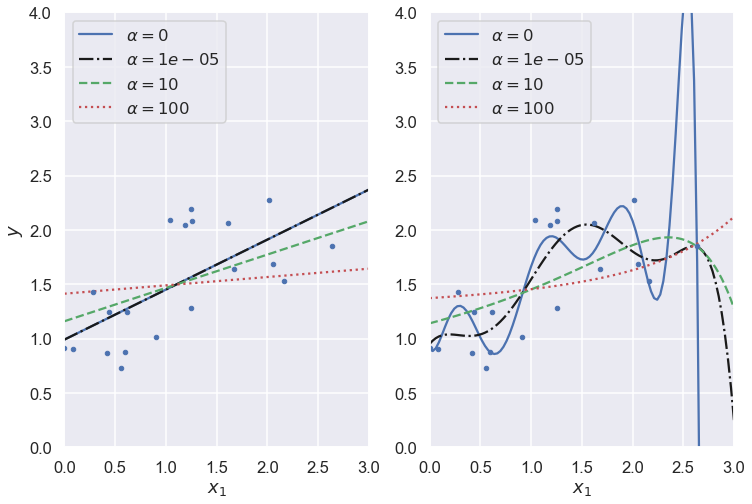

In [64]:
fig,axs = plt.subplots(1,2,figsize=(12,8))

alphas=(0, 1e-5,10, 100)
for i,degree in enumerate((1,10)):
    ax = axs[i]
    for alpha, style in zip(alphas, ("b-", "k-.", "g--", "r:")):
        y_new_regul = train_ridge_model(X, y, alpha, X_predict=X_new, degree=degree, random_state=42)
        ax.plot(X_new, y_new_regul, style, label=r'$\alpha={}$'.format(alpha))
    ax.plot(X, y, "b.")
    ax.legend(loc="upper left")
    ax.set_xlabel("$x_1$")
    ax.axis([0, 3, 0, 4])

axs[0].set_ylabel("$y$");